# Advanced Lane Finding Project

#### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip
from scipy.misc import imsave
%matplotlib inline

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

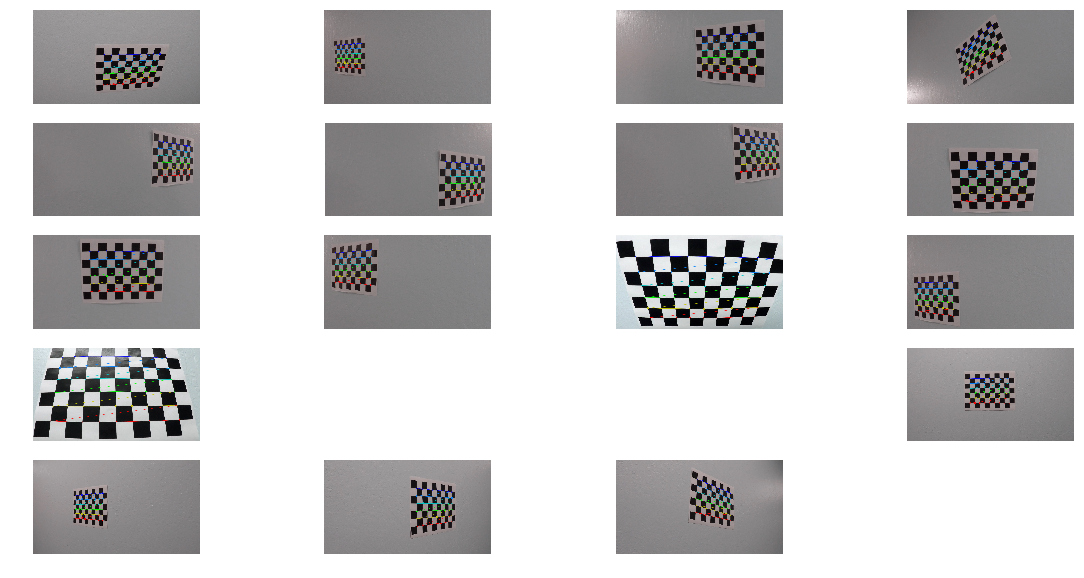

In [2]:
# Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

plt.figure(figsize=(20, 10))

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        img_name = 'output_images/corners' + str(idx) + '.jpg'
        cv2.imwrite(img_name, img)
        plt.subplot(5, 4, idx)
        plt.axis('off')
        plt.imshow(img)          

In [3]:
# Load image 
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open('calibration.p', 'wb')) 

### 2. Apply a distortion correction to raw images

(-0.5, 1279.5, 719.5, -0.5)

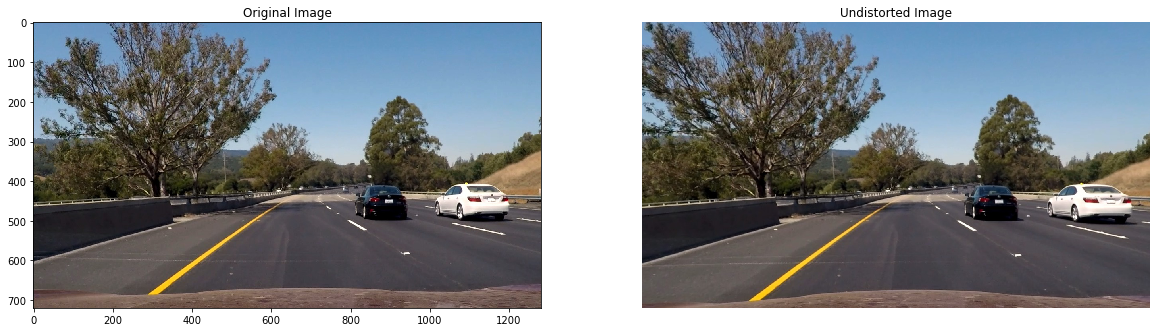

In [4]:
dist_pickle = pickle.load(open('calibration.p', 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Test undistortion on a road test image
test_img = mpimg.imread('test_images/test6.jpg')
test_img_size = (img.shape[1], img.shape[0])
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

# Preview one image
f, (plt1, plt2)  = plt.subplots(1, 2, figsize=(20,10))
plt1.imshow(test_img)
plt1.set_title('Original Image')
plt2.imshow(undist)
plt2.set_title('Undistorted Image')
plt.axis('off')

### 3. Use color transforms, gradients, etc., to create a thresholded binary image

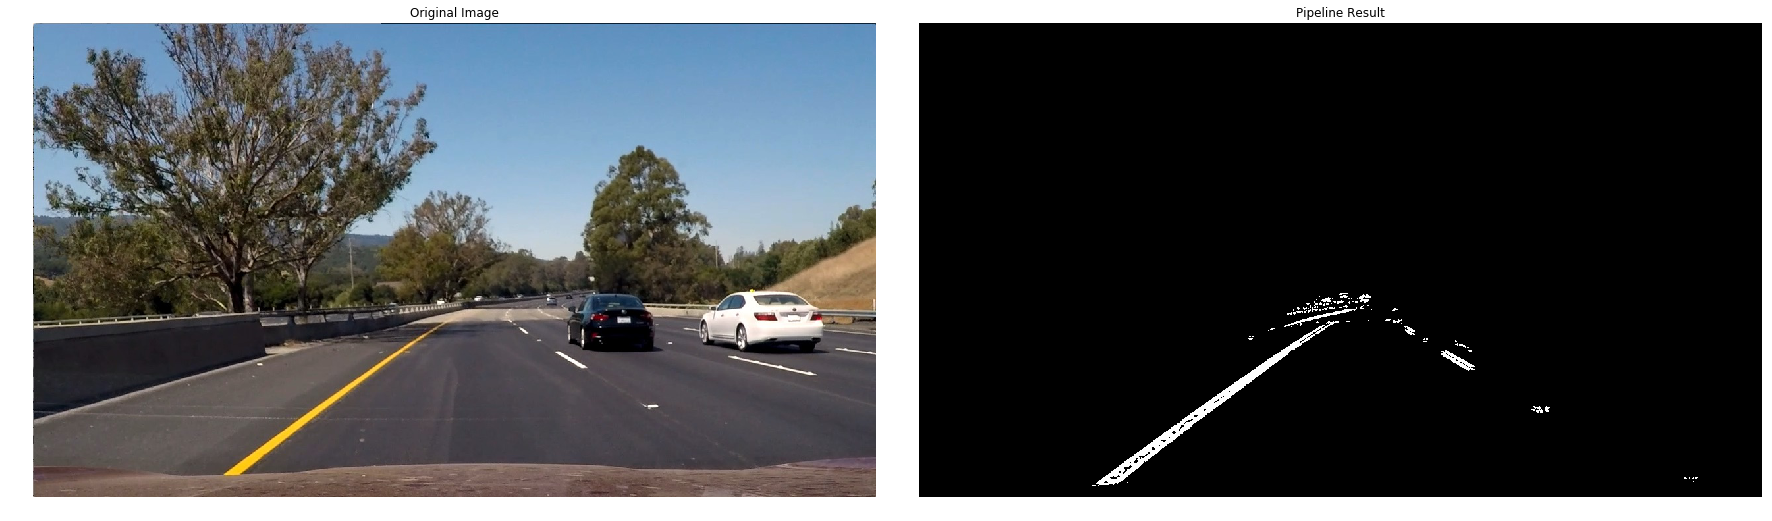

In [34]:
# Combined transforms and gradients pipeline.
def region_of_interest(img, vertices):
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

# Edit this function to create your own pipeline.
def combined_thresh(img):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    
    # Return binary image
    return color_binary
    
result = combined_thresh(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result')
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4. Perspective Transform ("birds-eye view")

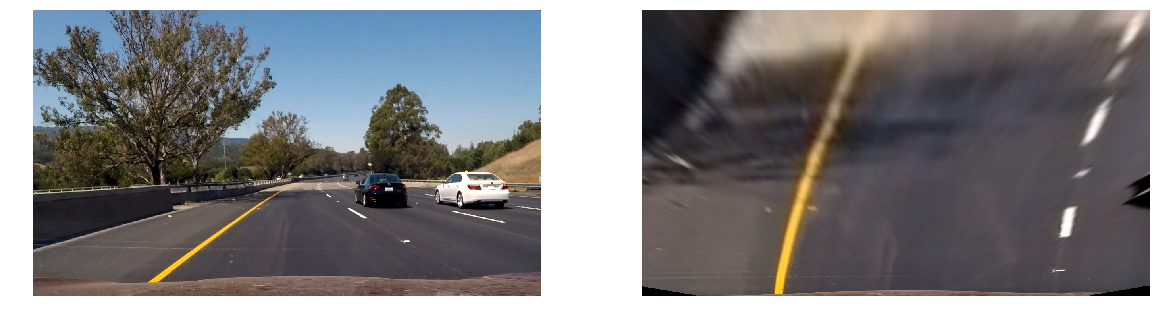

In [47]:
def perspective_transform(img):
    # Define source and destination points for perspective transform
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])

    # Perform the transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return Minv, warped

Minv, warped = perspective_transform(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.axis('off')
ax1.imshow(test_img)
ax2.axis('off')
ax2.imshow(warped)

In [35]:
def find_lanes(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    b_out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(b_out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(b_out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty

def fit_lines(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx

### 5. Measuring Curvature

In [36]:
def find_curvature(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now return radius of curvature in meters
    return left_curverad, right_curverad

(0.0, 1280.0, 720.0, 0.0)

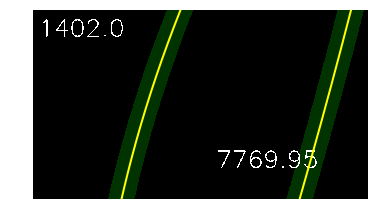

In [39]:
# Prepare image for lane finding
w_img = combined_thresh(undist)
min_v, w_img = perspective_transform(w_img)  
out_img = np.dstack((w_img, w_img, w_img))*255
win_img = np.zeros_like(out_img)

# Find lanes and fit a polynomial to them
leftx, lefty, rightx, righty = find_lanes(w_img)
ploty, left_fitx, right_fitx = fit_lines(w_img, leftx, lefty, rightx, righty)

curvature = find_curvature(ploty, leftx, lefty, rightx, righty)
    
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

margin = 50

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
l_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
l_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
l_line_pts = np.hstack((l_line_window1, l_line_window2))
r_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
r_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
r_line_pts = np.hstack((r_line_window1, r_line_window2))

# Draw lines on image and save it
cv2.fillPoly(win_img, np.int_([l_line_pts]), (0,255, 0))
cv2.fillPoly(win_img, np.int_([r_line_pts]), (0,255, 0))
res_img = cv2.addWeighted(out_img, 1, win_img, 0.3, 0)

# Write curvature on fitted lines
text_left = str(round(curvature[0], 2))
color = (1, 1, 1)
cv2.putText(res_img, text_left, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)
text_right = str(round(curvature[1], 2))
cv2.putText(res_img, text_right, (700, 600), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)   

# Show results
plt.plot(left_fitx, ploty, color='yellow',linewidth=2.0)
plt.plot(right_fitx, ploty, color='yellow',linewidth=2.0)
plt.imshow(res_img)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis('off')

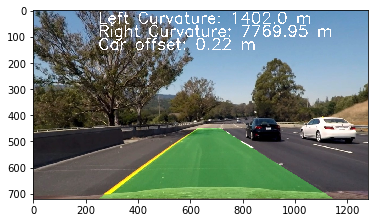

In [40]:
def car_offset(result, pts_left, pts_right):
    xm_per_pix = 3.7 / 700
    lane_difference = pts_right[0, pts_right[0,:,1].argmax(), 0] - pts_left[0, pts_left[0,:,1].argmax(), 0]
    offset = (lane_difference - result.shape[1]/2) * xm_per_pix
    return offset

def draw_lane_on_img(warped, ploty, left_fitx, right_fitx, Minv, undist, left_curv, right_curv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    res = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Write the results on images using OpenCV 
    color = (255,255,255)
    txt = "Left Curvature: {} m".format(round(left_curv, 2))
    cv2.putText(res, txt, (250, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3)
    txt = "Right Curvature: {} m".format(round(right_curv, 2))
    cv2.putText(res, txt, (250, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3)
    center_offset = car_offset(res, pts_left, pts_right)
    txt = "Car offset: {} m".format(round(center_offset, 2))
    cv2.putText(res, txt, (250, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3)

    return res

curv = find_curvature(ploty, leftx, lefty, rightx, righty)
final = draw_lane_on_img(w_img, ploty, left_fitx, right_fitx, min_v, undist, curv[0], curv[1])
plt.imshow(final)

### Save images to output  folder

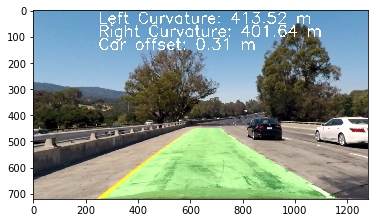

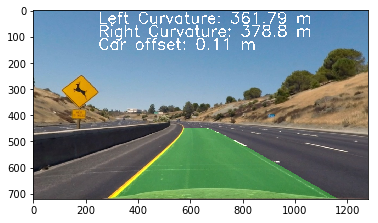

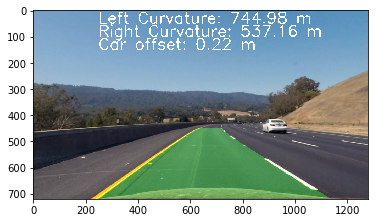

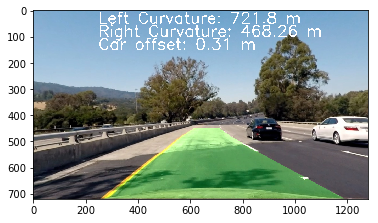

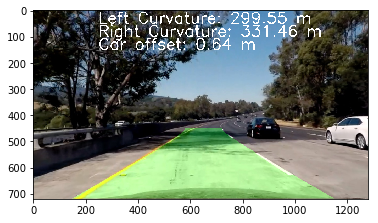

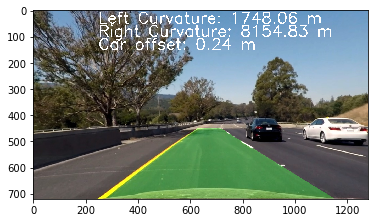

In [51]:
test_images = glob.glob('test_images/test*.jpg')

# Loop through all test images and save modified copy in output folder
for i, test_image in enumerate(test_images):
    # Image adjustments
    img = cv2.imread(test_image)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    undist_name = 'output_images/undist' + str(i) + '.png'
    cv2.imwrite(undist_name, img)
    
    # Save unwarped thresholded images
    unmod_thresh = combined_thresh(img)
    unmod_threshold_name = 'output_images/unmod_threshold' + str(i) + '.png'
    pyplot.imsave(unmod_threshold_name, combined_thresh(img), cmap='gray')
    
    # Do perpective transform    
    min_v, img = perspective_transform(unmod_thresh)
    # Save a copy from warped undistorted image before applying thresholding
    unmod_minv, unmod_warped_img = perspective_transform(undist_img)
    warped_name = 'output_images/warped' + str(i) + '.png'
    cv2.imwrite(warped_name, unmod_warped_img)

    ### Finding lanes ###
    # Prepare image for finding lanes
    c_out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    
    # Find lanes
    leftx, lefty, rightx, righty = find_lanes(img)
    ploty, left_fitx, right_fitx = fit_lines(img, leftx, lefty, rightx, righty)
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calaculate curvature
    curv = find_curvature(ploty, leftx, lefty, rightx, righty)
    
    # Color in left and right line pixels
    c_out_img[lefty, leftx] = [255, 0, 0]
    c_out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw lines on image and save it
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(c_out_img, 1, window_img, 0.3, 0)
    c_name = 'output_images/c_' + str(i) + '.png'
    pyplot.imsave(c_name, result_img)
    
    # Draw complete lane area on image and save it
    img = draw_lane_on_img(img, ploty, left_fitx, right_fitx, min_v, undist_img, curv[0], curv[1])
    img_name = 'output_images/img' + str(i) + '.png'
    cv2.imwrite(img_name, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.figure()

In [44]:
# Add all image adjustments together
def process_image(frame):
    undistort = cv2.undistort(frame, mtx, dist, None, mtx)
    thresh = combined_thresh(undistort)
    Min_v, binary_warp = perspective_transform(thresh)
    #binary_warp = combined_thresh(warp)
    left_x, left_y, right_x, right_y = find_lanes(binary_warp)
    plot_y, left_fit_x, right_fit_x = fit_lines(binary_warp, left_x, left_y, right_x, right_y)
    l_curv, r_curv = find_curvature(ploty, leftx, lefty, rightx, righty)
    
    return draw_lane_on_img(binary_warp, plot_y, left_fit_x, right_fit_x, Min_v, undistort, l_curv, r_curv)

def run(frame):
    return process_image(frame)

### Test pipeline on video and save output

In [45]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(run)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:02<00:00,  4.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 7s, sys: 1min 12s, total: 6min 20s
Wall time: 5min 2s
